### Creation of Image Classifier using CNN

- CNNs allow for multi-class classification (e.g. identifying handwritten digits 0 to 9)

#### Topic: CNNs

- CNNs work by moving a receptive field across an image (e.g. think of this receptive field like a magnifying glass moving across an undeveloped film). Only portions of the image are within the view at a particular point.
- Filters are repurposed to recognize patterns throughout an image
- A filter is a matrix of numbers
- CNNs are arranged in (3D)
    - Width
    - Length
    - Depth (e.g. RGB with values on a scale of 0 to 255)
        - R -> Amount of redness between 0 and 255)
        - G -> Amount of greenness between 0 and 255)
        - B -> Amount of blueness between 0 and 255)
-

#### Topic: Agenda




In [6]:
# Installation of Imports
from IPython.display import Image # Used to display images in the notebook

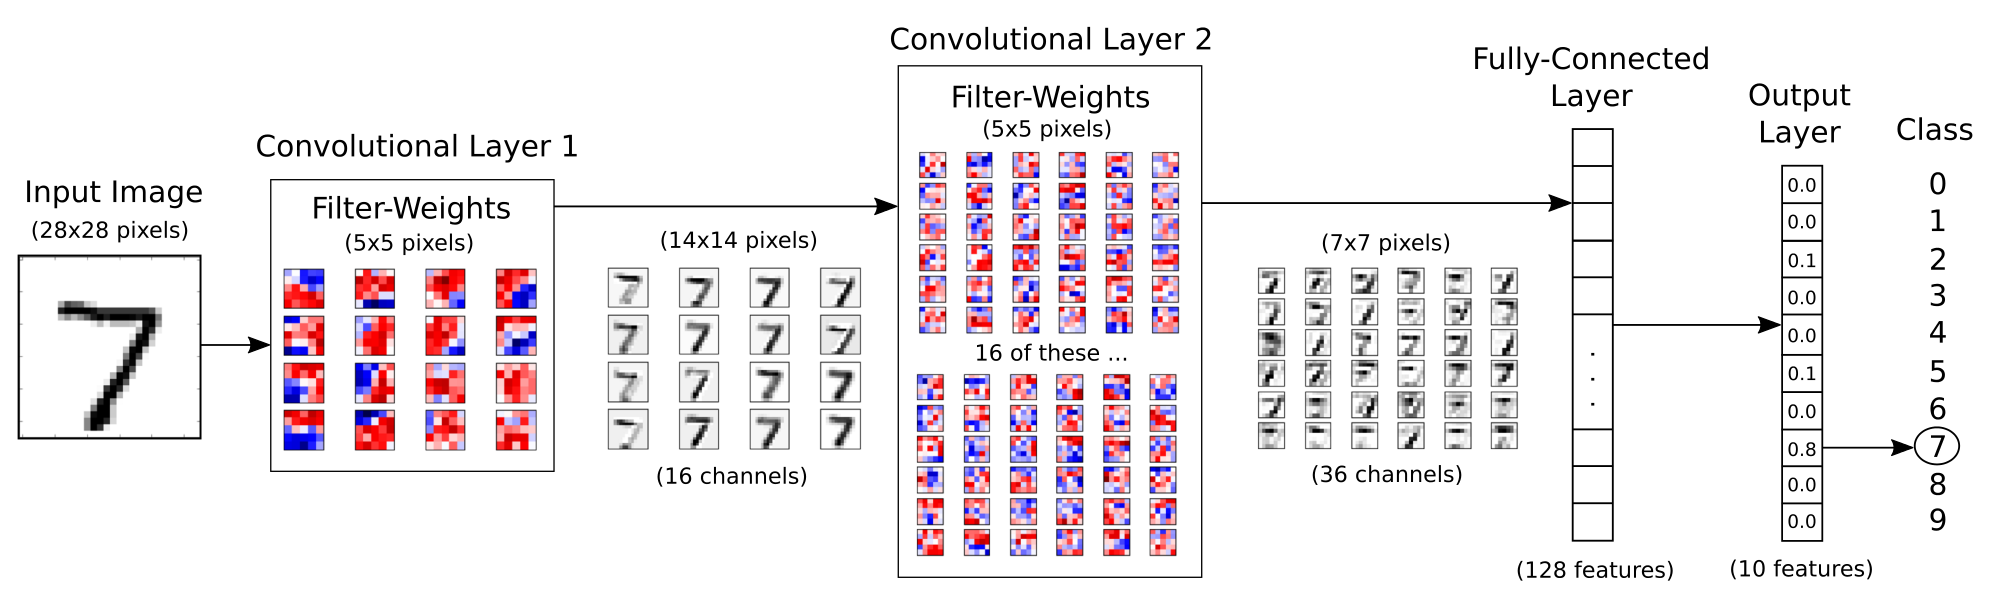

In [7]:
#### Topic: Flowchart of CNN
Image('images/CNN_visual_01.png')

#### Topic: Breakdown of FlowChart

- (Section: Input Image)
- (Convolutional Layer 1)
    - Image processed using filter weights
    - 16 new images are created from the input image during this operation
    - Resulting images are down-sampled to (14 x 14 pixels)
- (Output Layer 1)
- (Convolutional Layer 2)
    - 16 filter weights are required per the 16 channel input and 36 filter weights are required per the 36 channel output.
    - This is a total of 576 filter-weights
    - Resulting images are down-sampled to (7 x 7 pixels)
- (Output Layer 2)
    - The 36 images with dimension (7 x 7 pixels) are flattened into a single vector of shape 7 x 7 x 36
- (Fully Connected Layer)
    - This inputs the output layer 2 to a fully connected layer of 128 neurons
- (Final Output Layer)
    - This inputs the previous layer to a fully connected layer of 10 neurons (e.g. 0 thru 9)
- (Class)
    - Prediction of the hand-written digit is provided a probability
    
    
- Side Notes:
    - The original filter weights are randomly selected
    - The cross-entropy is the error between the predicted value and the actual hand-written digit
    - An optimizer is used to update filter weights back through the network using chain rule of differentiation to increase the accuracy of the classification error
    


#### Topic: Convolutional Layer

- A convolutional network may be thought of as consisting of (2) main elements
    - (1) Feature Learning -> (3) operations occur repeatedly (e.g. Convolutional Block)
        - Apply Convolution 
            - Filter moved to various points of image (i.e. dot product applied to filter and region of image); Moving the filter across the entire image results in a new image; The filter will either have positive reactions (e.g. pattern identified) or negative reactions (e.g. not relevant) to the input image regions. The distance the filter is moved horizontally and vertically across an image is called the stride (e.g. stride = 1 pixel). Pad the filter with zeros once it has scanned the entire image and reached the lower right corner of an image.
        - ReLU: Rectified Linear Unit (e.g. activation)
            - Ensures the output is positive b/c negatives are converted to zero
        - Pooling
            - This halves the resolution of the image and only maintains the largest pixels from the filter dot product input image computation
    - (2) Classification
        - Flatten output of Convolutional blocks to smaller dimension vector
        - Connect all the neurons from one layer to the next to leverage the learning from the previous layers

In [9]:
# Import Libraries
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

/Users/blackice02/Documents/006_Make_Money_w_ML_Course/ML_Practice_Projects_2019/01_Image_Classifier/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/blackice02/Documents/006_Make_Money_w_ML_Course/ML_Practice_Projects_2019/01_Image_Classifier/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/blackice02/Documents/006_Make_Money_w_ML_Course/ML_Practice_Projects_2019/01_Image_Classifier/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of t

Display the version of tensorflow

In [10]:
tf.__version__

'1.14.0'

### Step 1: Configuration of Neural Network

In [11]:
### Convolutional Layer 1
filter_size1 = 5 # Convo filters is 5x5 px
num_filters1 = 16 # Refers to the 16 channels in the output layer above

### Convolutional Layer 2
filter_size2 = 5 # Convo filters is 5x5 px
num_filters2 = 36 # Refers to the 36 channels in the output layer above

### Fully-Connected Layer
fc_layer = 128 # Refers to the number of neurons in the fully connencted layer

### Step 2: Load MNIST dataset (e.g. consists of 70k+ images with assoc. labels)

In [14]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST', one_hot = True)

# Tip: One_Hot Encoding allows us to turn nominal categorical data into features with numerical values. Each label is a vector with 10 elements (e.g. 0 to 9)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

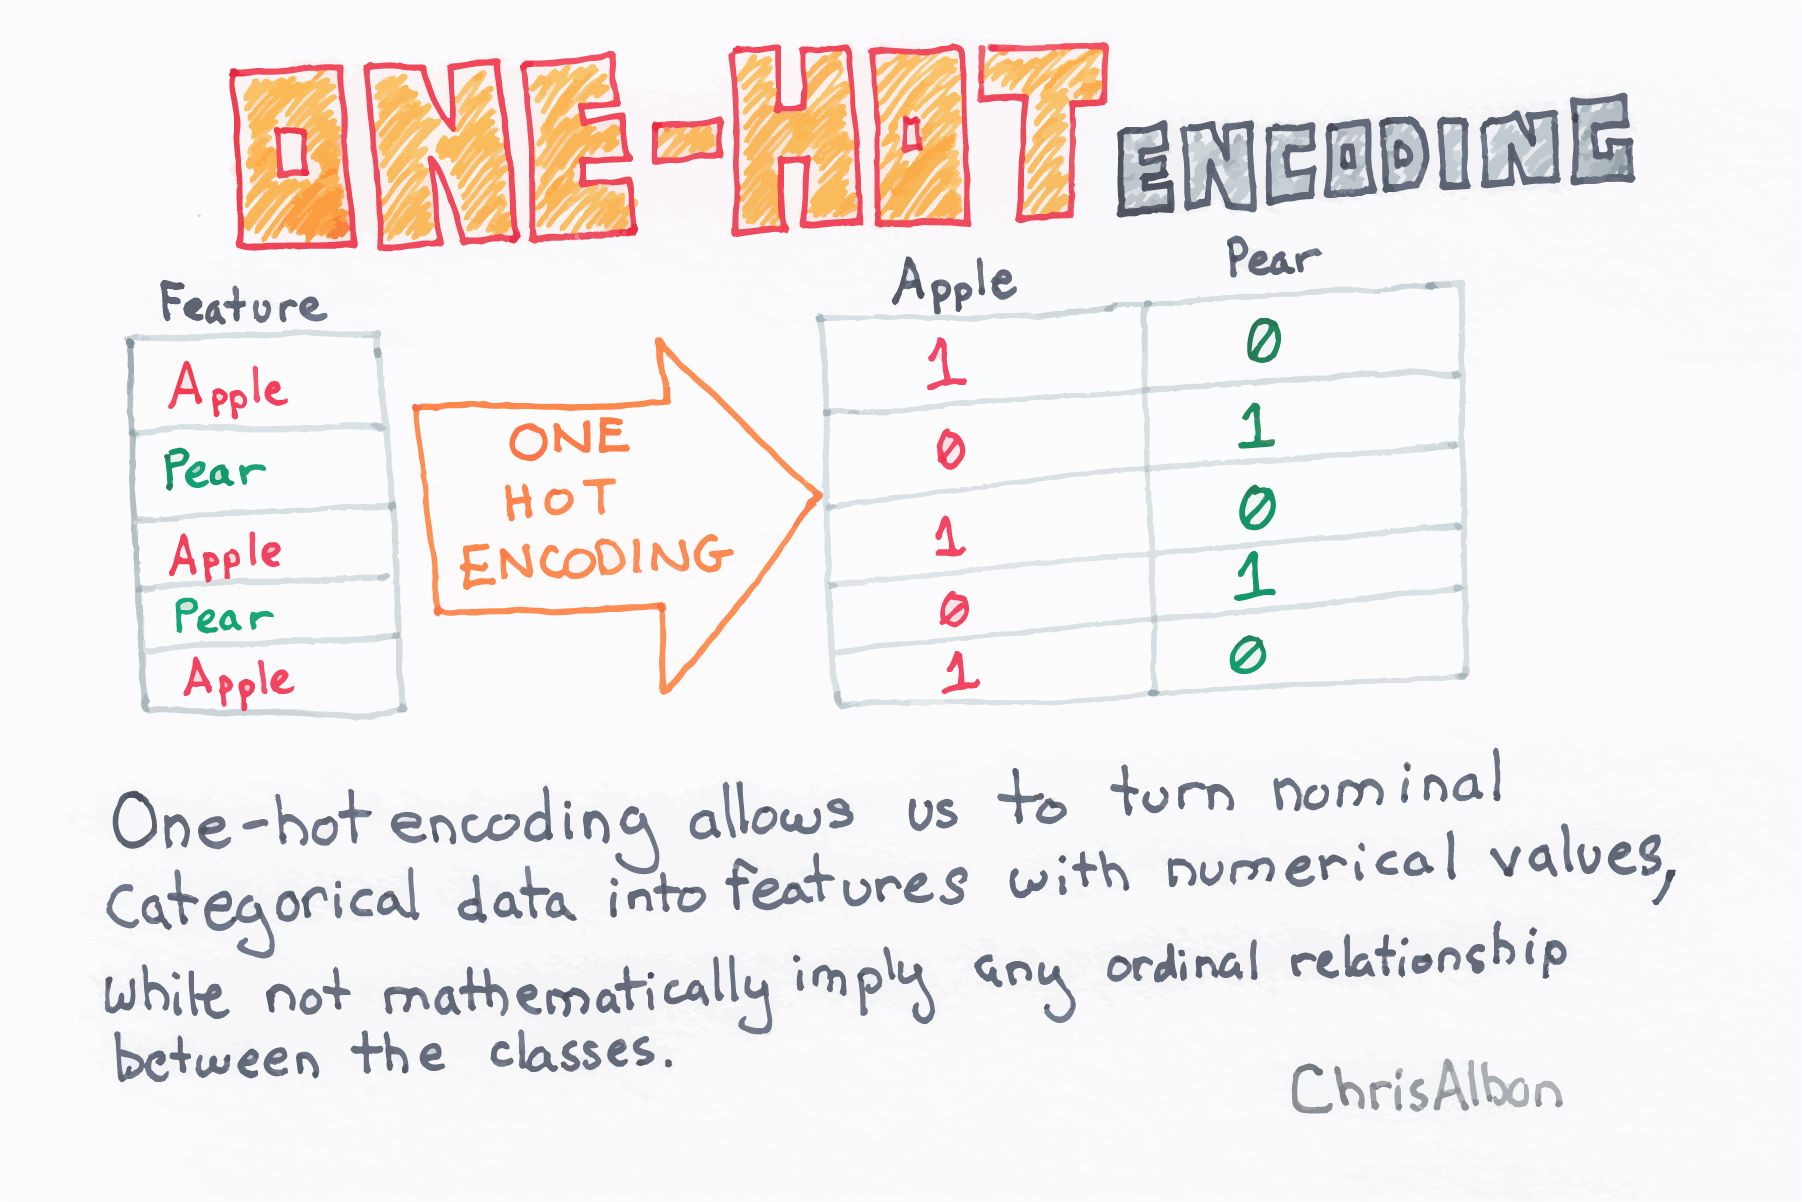

In [13]:
#### Topic: Visual of One Hot Encoding
Image('images/One-Hot_Encoding_print.png')


In [15]:
#### MNIST dataset is split into (3) subsets
print("Size of subsets are as follows:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of subsets are as follows:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [16]:
#### Obtain test-set class-numbers as integers
data.test.cls = np.argmax(data.test.labels, axis=1)

### Step 3: Data Dimensions declaration

In [17]:
### MNIST images are 28 x 28 in dimension
img_size = 28


### One-dimensional arrays to store images
img_size_flat = img_size * img_size

### Height and width of image tuple to reshape arrays
img_shape = (img_size, img_size)

### Specify the number of color channels for the images: We will only have 1 channel for gray-scale
### Channels refers to the number of primary colors
num_channels = 1

### Specify the number of classes. There are 10 digits, one for each class (e.g. 0 thru 9)
num_classes = 10


### Step 4: Helper Function to Plot Images

In [24]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    ### Create figure with 3x3 sub-plots with matplotlib
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    for i, ax in enumerate(axes.flat):
        ### Display the image
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        
        ### Display true and prediction
        if cls_pred is None:
            xlabel = "True: {}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
            
        ### Display classes as x labels
        ax.set_xlabel(xlabel)
        
        ### Remove the ticks from the plot for aesthetics
        ax.set_xticks([])
        ax.set_yticks([])
        
    ### Ensure plot displays the 3x3 subplots
    plt.show()

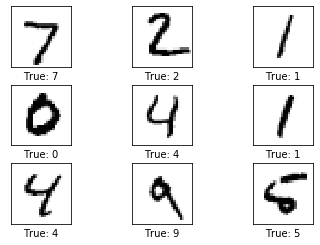

In [25]:
### Plot a few images to confirm coding correct

### Obtain first (9) images from test-set
images = data.test.images[0:9]

### Obtain the true classes for the first 9 images
cls_true = data.test.cls[0:9]

### Use helper function to plot the images and class names
plot_images(images = images, cls_true = cls_true)

### Step 5: TensorFlow Graph

#### Topic: TensorFlow

- Due to the capability of parallel computations, tensorflow is more efficient than just using pure numpy
- TensorFlow understands the entire computational graph that is to be executed
- Numpy only conducts a single mathematical computation at a time
- TensorFlow can automatically calculate gradients for error reduction via back propagation

- Parts of a TensorFlow Graph
    - Placeholder variables for graph data inputs
    - Optimizing variables
    - Mathematical formulas for the convolutional network
    - The cost measure that guides variable optimization
    - The optimization method that updates variables

### Step 6: Create Helper Function for creating new variables

In [27]:
### Functions to create TensorFlow variables
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    ### Think of this as the y intercept from y = mx + b from linear algebra
    return tf.Variable(tf.constant(0.05, shape=[length]))

### Step 7: Create Helper Function for creating New Convolutional Layer

### Add mathematical formulas to the TensorFlow graph to create a new Convolutional Layer
- Assumes (4d) tensor
    - image number
    - x-axis of each image
    - y-axis of each image
    - channels of each image (i.e. channels may either be color-channels or filter channels depending on the previous layer
    
- Output is (4d) tensor
    - image number, same as input
    - x-axis of image (i.e. If 2x2 pooling is used, then we divide the height and width by 2)
    - y-axis of image (i.e. If 2x2 pooling is used, then we divide the height and width by 2)
    - channels generated by convolutional filters